# Clustering Clientes Supermercados

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import math
from collections import Counter


from sklearn.cluster import KMeans
from sklearn.metrics import confusion_matrix, accuracy_score, silhouette_samples, silhouette_score, calinski_harabaz_score
from sklearn import preprocessing
from sklearn.decomposition import PCA

Vamos a realizar operaciones de **clustering** (segmentación) de datos.
La idea es encontrar una estructura dentro de un dataset donde originalmente no la había.
No se tiene un objetivo de predicción (se trata **aprendizaje no supervisado**), sino de uno de entendimiento de los datos a través del particionamiento del dataset en grupos de instancias.

In [2]:
data = pd.read_csv('01-ComprasClientes.csv', na_values=".")
print(data.shape)
data.head(5)

(440, 8)


,Channel,Region,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
0,2,3,12669,9656,7561,214,2674,1338
1,2,3,7057,9810,9568,1762,3293,1776
2,2,3,6353,8808,7684,2405,3516,7844
3,1,3,13265,1196,4221,6404,507,1788
4,2,3,22615,5410,7198,3915,1777,5185


In [3]:
data.describe(include="all")

,Channel,Region,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
count,440.000000,440.000000,440.000000,440.000000,440.000000,440.000000,440.000000,440.000000
mean,1.322727,2.543182,12000.297727,5796.265909,7951.277273,3071.931818,2881.493182,1524.870455
std,0.468052,0.774272,12647.328865,7380.377175,9503.162829,4854.673333,4767.854448,2820.105937
min,1.000000,1.000000,3.000000,55.000000,3.000000,25.000000,3.000000,3.000000
25%,1.000000,2.000000,3127.750000,1533.000000,2153.000000,742.250000,256.750000,408.250000
50%,1.000000,3.000000,8504.000000,3627.000000,4755.500000,1526.000000,816.500000,965.500000
75%,2.000000,3.000000,16933.750000,7190.250000,10655.750000,3554.250000,3922.000000,1820.250000
max,2.000000,3.000000,112151.000000,73498.000000,92780.000000,60869.000000,40827.000000,47943.000000


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 440 entries, 0 to 439
Data columns (total 8 columns):
Channel             440 non-null int64
Region              440 non-null int64
Fresh               440 non-null int64
Milk                440 non-null int64
Grocery             440 non-null int64
Frozen              440 non-null int64
Detergents_Paper    440 non-null int64
Delicassen          440 non-null int64
dtypes: int64(8)
memory usage: 27.6 KB


## Preparación de los datos

1. Las variables Channel y Region tienen tipo int64, cuando en realidad codifican categorías de canales y de regiones. Es necesario cambiar sus tipos.
1. Tenemos en todas las variables de consumo valores anormalmente grandes que pueden considerarse excepciones en el mejor de los casos (anomalías o errores de captura en el peor de los casos). Hay que identificar los registros en cuestión y evaluar la posibilidad de descartarlos pues pueden influenciar negativamente muchos de los modelos que se pueden aprender a partir de los datos.
1. Las escalas de las variables que denotan los montos consumidos de cada tipo de productos son muy disparejas. Es necesario normalizar los datos ya que de no hacerlo se otorgaría una importancia demasiado desmedida a variables como Fresh casi que ignorando variables como Delicatessen.

Arreglamos primero los tipos de datos incorrectos:

In [5]:
data.Channel = data.Channel.astype(str)
data.Region = data.Region.astype(str)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 440 entries, 0 to 439
Data columns (total 8 columns):
Channel             440 non-null object
Region              440 non-null object
Fresh               440 non-null int64
Milk                440 non-null int64
Grocery             440 non-null int64
Frozen              440 non-null int64
Detergents_Paper    440 non-null int64
Delicassen          440 non-null int64
dtypes: int64(6), object(2)
memory usage: 27.6+ KB


Antes de normalizar es necesario limpiar las excepciones o anomalías con valores o muy grandes o muy pequeñas. Vamos a analizar las variables numéricas a partir de diagramas de cajas y bigotes.

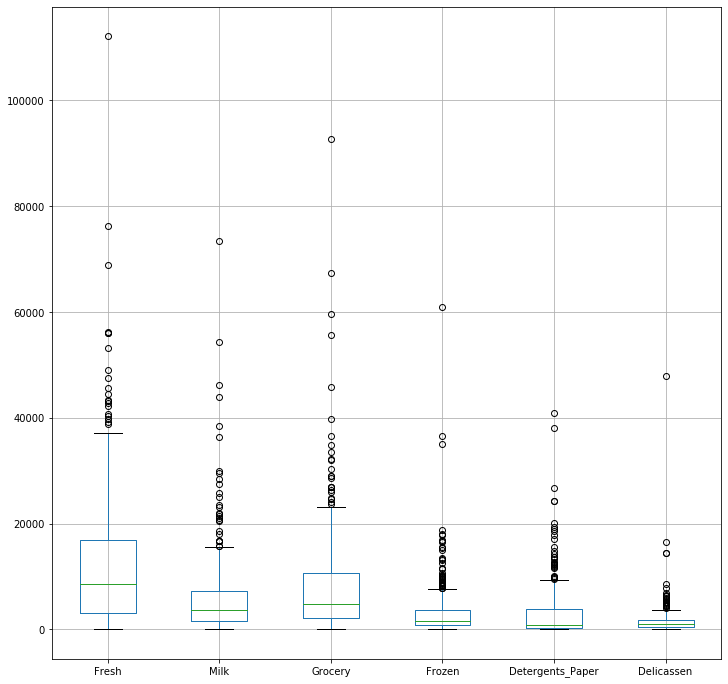

In [6]:
plt.figure(figsize=(12,12))
data.boxplot()

Vemos que hay valores muy importantes en todas las variables. Si contamos los puntos individuales más elevados podemos identificar 6 o menos puntos que sobrepasan la mayoría de los demás.
Puede que algunos de los puntos excepcionales en las diferentes variables correspondan a los mismos individuos. Vamos a identificar los top 6 de valores mas importantes en cada tipo de producto y no los vamos a considerar en los análisis siguientes.

In [7]:
temp = data.sort_values(['Fresh'], ascending=False)
print("Excepciones de Fresh: ", np.sort(temp[0:6].index))
indicesAQuitar = temp[0:6].index

temp = data.sort_values(['Milk'], ascending=False)
print("Excepciones de Milk: ", np.sort(temp[0:6].index))
indicesAQuitar = np.union1d(indicesAQuitar, temp[0:6].index)

temp = data.sort_values(['Grocery'], ascending=False)
print("Excepciones de Grocery: ", np.sort(temp[0:6].index))
indicesAQuitar = np.union1d(indicesAQuitar, temp[0:6].index)

temp = data.sort_values(['Frozen'], ascending=False)
print("Excepciones de Frozen: ", np.sort(temp[0:6].index))
indicesAQuitar = np.union1d(indicesAQuitar, temp[0:6].index)

temp = data.sort_values(['Detergents_Paper'], ascending=False)
print("Excepciones de Detergents_Paper: ", np.sort(temp[0:6].index))
indicesAQuitar = np.union1d(indicesAQuitar, temp[0:6].index)

temp = data.sort_values(['Delicassen'], ascending=False)
print("Excepciones de Delicassen: ", np.sort(temp[0:6].index))
indicesAQuitar = np.union1d(indicesAQuitar, temp[0:6].index)

indicesAQuitar

Excepciones de Fresh:  [ 39 103 125 181 258 284]
Excepciones de Milk:  [ 23  47  61  85  86 183]
Excepciones de Grocery:  [ 47  61  65  85 211 333]
Excepciones de Frozen:  [ 93 103 183 196 325 413]
Excepciones de Detergents_Paper:  [ 47  61  65  85  86 333]
Excepciones de Delicassen:  [  2  23  71  87 181 183]


array([  2,  23,  39,  47,  61,  65,  71,  85,  86,  87,  93, 103, 125,
       181, 183, 196, 211, 258, 284, 325, 333, 413], dtype=int64)

Tenemos 22 registros identificados como excepciones. Vemos que algunos tienen valores excepcionales según diferentes tipos de consumo (23, 47, 61, 65, 85, ...)

In [8]:
data.shape

(440, 8)

In [9]:
dataDepurado = data.loc[~data.index.isin(indicesAQuitar)]
dataDepurado.shape

(418, 8)

Vamos ahora a normalizar los datos para que todas las variables tengan la misma importancia. Solo vamos a considerar los datos numéricos, por lo que no incluimos las variables Channel y Region.

In [10]:
dataStd = pd.DataFrame(preprocessing.scale(dataDepurado.iloc[:,2:]))
dataStd.columns=dataDepurado.columns[2:]

In [11]:
dataStd.mean(axis=0)

Fresh               1.540501e-17
Milk               -6.188564e-17
Grocery             3.612209e-17
Frozen             -3.665330e-17
Detergents_Paper    9.774212e-17
Delicassen          4.940227e-17
dtype: float64

In [12]:
dataStd.std(axis=0)

Fresh               1.001198
Milk                1.001198
Grocery             1.001198
Frozen              1.001198
Detergents_Paper    1.001198
Delicassen          1.001198
dtype: float64

## Clustering con K=3

In [13]:
kmeans = KMeans(n_clusters=3, random_state=0, n_init=10)
kmeans.fit(dataStd.iloc[:,0:6])

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=3, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=0, tol=0.0001, verbose=0)

In [14]:
print("Le tomó a KMeans", kmeans.n_iter_, "iteraciones llegar a convergencia, con un WSS final de:",
      kmeans.inertia_, "y los centroides siguientes:", kmeans.cluster_centers_)

Le tomó a KMeans 11 iteraciones llegar a convergencia, con un WSS final de: 1389.125986554681 y los centroides siguientes: [[-0.54265067  1.30970855  1.56507053 -0.35585007  1.56828129  0.34695352]
 [-0.27589129 -0.41913581 -0.44117296 -0.30271382 -0.38972917 -0.31984657]
 [ 1.21368532 -0.15258411 -0.33507495  1.10757898 -0.46973042  0.49396266]]


In [15]:
kmeans.labels_

array([1, 0, 2, 2, 1, 1, 1, 1, 0, 0, 1, 2, 0, 0, 1, 0, 1, 2, 1, 1, 1, 2,
       2, 1, 1, 1, 0, 2, 2, 1, 1, 2, 1, 1, 2, 0, 0, 2, 2, 0, 0, 1, 0, 0,
       1, 0, 1, 1, 2, 0, 2, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 2, 1, 2, 2,
       2, 1, 2, 1, 0, 1, 1, 1, 0, 0, 1, 1, 2, 2, 1, 2, 0, 0, 1, 1, 1, 1,
       1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 2, 1, 1, 1, 1, 1, 2, 1, 1, 1,
       1, 1, 2, 2, 2, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 1,
       0, 1, 1, 1, 2, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0,
       1, 1, 1, 0, 0, 1, 0, 1, 0, 2, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 2,
       1, 1, 0, 1, 2, 1, 1, 1, 0, 0, 2, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0,
       0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 2, 2, 1, 1, 1, 2, 1, 1,
       2, 1, 2, 2, 2, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 2, 2, 2, 2, 1, 1, 2,
       1, 1, 1, 1, 0, 0, 0, 2, 0, 1, 1, 1, 1, 2, 1, 1, 2, 2, 2, 1, 1, 1,
       2, 2, 2, 1, 2, 1, 2, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0,
       0, 0, 1, 1, 0, 2, 2, 0, 1, 1, 0, 1, 1, 1, 0,

También podemos utilizar el objeto kmeans resultante como modelo de clasificación, al que a través del método *predict* se le puede enviar un dataset para evaluar y obtener los clusters a los que pertenecen. Por ejemplo, utilicemoslo para clasificar los mismos ejemplos de entrenamiento:

In [16]:
clusters = kmeans.predict(dataStd.iloc[:, 0:6])
clusters

array([1, 0, 2, 2, 1, 1, 1, 1, 0, 0, 1, 2, 0, 0, 1, 0, 1, 2, 1, 1, 1, 2,
       2, 1, 1, 1, 0, 2, 2, 1, 1, 2, 1, 1, 2, 0, 0, 2, 2, 0, 0, 1, 0, 0,
       1, 0, 1, 1, 2, 0, 2, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 2, 1, 2, 2,
       2, 1, 2, 1, 0, 1, 1, 1, 0, 0, 1, 1, 2, 2, 1, 2, 0, 0, 1, 1, 1, 1,
       1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 2, 1, 1, 1, 1, 1, 2, 1, 1, 1,
       1, 1, 2, 2, 2, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 1,
       0, 1, 1, 1, 2, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0,
       1, 1, 1, 0, 0, 1, 0, 1, 0, 2, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 2,
       1, 1, 0, 1, 2, 1, 1, 1, 0, 0, 2, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0,
       0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 2, 2, 1, 1, 1, 2, 1, 1,
       2, 1, 2, 2, 2, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 2, 2, 2, 2, 1, 1, 2,
       1, 1, 1, 1, 0, 0, 0, 2, 0, 1, 1, 1, 1, 2, 1, 1, 2, 2, 2, 1, 1, 1,
       2, 2, 2, 1, 2, 1, 2, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0,
       0, 0, 1, 1, 0, 2, 2, 0, 1, 1, 0, 1, 1, 1, 0,

In [17]:
counter=Counter(clusters)
print(counter)

Counter({1: 238, 2: 93, 0: 87})


Tenemos 3 clusters de 238, 93 y 87 instancias cada uno.
Agregamos una columna al dataframe con los datos analizados que indique a que cluster pertenece cada registro.

In [18]:
dataStd.loc[:,'Cluster'] = clusters

In [19]:
dataStd.columns

Index(['Fresh', 'Milk', 'Grocery', 'Frozen', 'Detergents_Paper', 'Delicassen',
       'Cluster'],
      dtype='object')

In [20]:
dataStd[0:5]

,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen,Cluster
0,0.189650,0.935012,0.073249,-0.805601,0.047187,0.083000,1
1,-0.371959,0.966262,0.364676,-0.273463,0.223754,0.448833,0
2,0.249293,-0.781752,-0.411737,1.322266,-0.570941,0.458856,2
3,1.184974,0.073383,0.020539,0.466650,-0.208678,3.296150,2
4,-0.136187,0.651522,-0.280326,-0.650222,-0.203544,0.177382,1


## Interpretación de los clusters, con k =3

Vamos a tratar de entender cuales son las características de los registros que componen los clusters. 

In [22]:
var_num = ['Fresh', 'Milk', 'Grocery', 'Frozen', 'Detergents_Paper', 'Delicassen']

In [23]:
import warnings
warnings.filterwarnings('ignore')

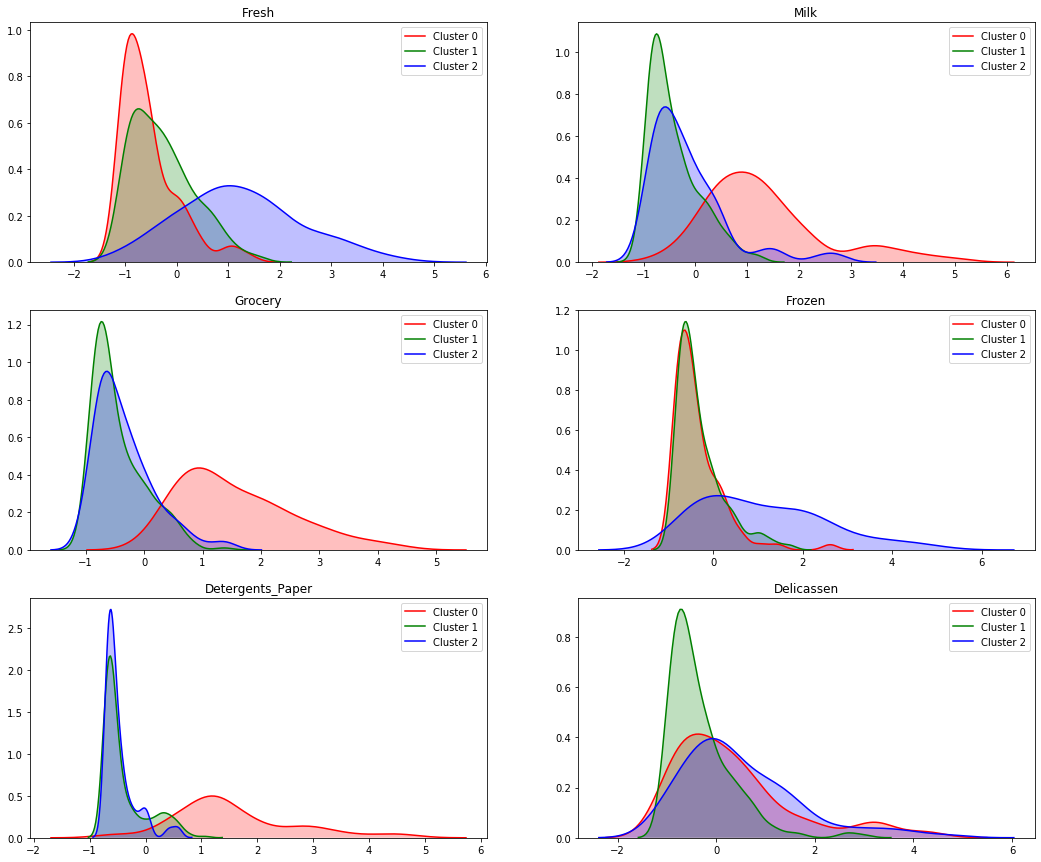

In [24]:
fig = plt.figure(figsize=(18,15))
i=1
for var in var_num:
    ax = fig.add_subplot(math.ceil(len(var_num)/2), 2, i)
    sns.kdeplot(dataStd.loc[dataStd.Cluster==0][var], shade=True, color='r', ax=ax);
    sns.kdeplot(dataStd.loc[dataStd.Cluster==1][var], shade=True, color='g', ax=ax);
    sns.kdeplot(dataStd.loc[dataStd.Cluster==2][var], shade=True, color='b', ax=ax);
    plt.title(var)
    plt.legend(['Cluster 0', 'Cluster 1', 'Cluster 2'])
    i+=1

Veámoslos en scatterplots para entender mejor las diferencias:

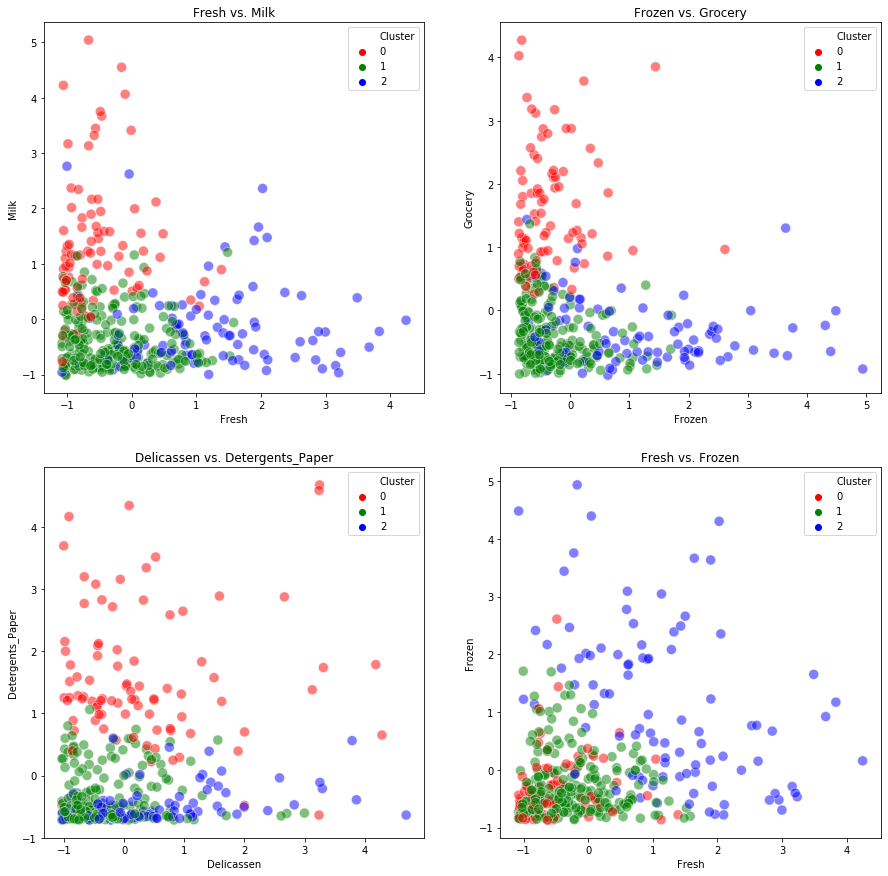

In [25]:
fig = plt.figure(figsize=(15,15))
colorPalette = ["r", "g", "b"]
ax = fig.add_subplot(2, 2, 1)
sns.scatterplot(x="Fresh", y="Milk", hue="Cluster", data=dataStd, ax=ax, palette=colorPalette, s=100, alpha=0.5)
plt.title("Fresh vs. Milk")
ax = fig.add_subplot(2, 2, 2)
sns.scatterplot(x="Frozen", y="Grocery", hue="Cluster", data=dataStd, ax=ax, palette=colorPalette, s=100, alpha=0.5)
plt.title("Frozen vs. Grocery")
ax = fig.add_subplot(2, 2, 3)
sns.scatterplot(x="Delicassen", y="Detergents_Paper", hue="Cluster", data=dataStd, ax=ax, palette=colorPalette, s=100, alpha=0.5)
plt.title("Delicassen vs. Detergents_Paper")
ax = fig.add_subplot(2, 2, 4)
sns.scatterplot(x="Fresh", y="Frozen", hue="Cluster", data=dataStd, ax=ax, palette=colorPalette, s=100, alpha=0.5)
plt.title("Fresh vs. Frozen")
plt.show()

Podemos interpretar entonces los clusters de esta manera:
- Cluster 0 (Rojo, 238 registros). Tiene valores:
    - Altos : Milk, Grocery, Detergents_Paper
    - Medios: Delicassen
    - Bajos : Fresh, Frozen
- Cluster 1 (Verde, 93 registros). Tiene valores:
    - Altos : 
    - Medios: 
    - Bajos : Fresh, Milk, Grocery, Frozen, Detergents_Paper, Delicassen
- Cluster 2 (Azul, 87 registros). Tiene valores:
    - Altos : Fresh, Frozen
    - Medios: Delicassen
    - Bajos : Milk , Grocery, Detergents_Paper
    

## Interpretación de los clusters, con k = 4

<font color="red">**Repitan el análisis con k=4.**</font>

...

...

...

...

# Parte 4. Determinación del K

### Codo

En el atributo *inertia_* queda el valor de la suma de las distancias cuadráticas entre cada punto y el centro del cluster al que pertenece (el **WSS** - Within Sum of Squares, también llamado más genéricamente **SSE** - Sum of Squared Errors)

In [26]:
kmeans.inertia_

1389.125986554681

In [27]:
kmeans.init

'k-means++'

A partir de los valores de WSS se puede crear el plot a partir del cual se aplica la técnica del codo, creando un clustering para diferentes valores de K. Veamos, según el método del codo, cual sería el valor del K en este conjunto de datos:

In [28]:
WSSs = []
for i in range(1,15) :
    km = KMeans(n_clusters=i, random_state=0)
    km.fit(dataStd)
    WSSs.append(km.inertia_)
WSSs

[2687.9138755980857,
 1786.5914626745173,
 1389.125986554681,
 1213.2310041377355,
 1064.6880826279717,
 934.150941593985,
 858.50253018533,
 799.293880637206,
 747.3371513350264,
 716.4198566919686,
 678.729780170117,
 643.6922231865867,
 614.7795677762151,
 595.8195068903864]

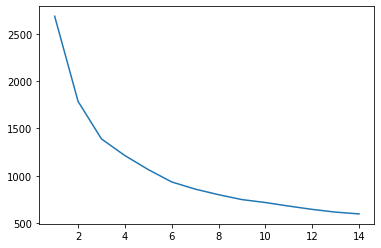

In [29]:
plt.plot(range(1, 15), WSSs)

Con K=3 encontramos aproximadamente el codo. 

### Silueta

Veamos ahora con el método de silueta cuántos clusters deberíamos tener. Obtengamos las siluetas para k = 2, 3, 4 y 5.

Veamos las siluetas de los puntos de cada cluster.
Vamos a crear un bar plot horizontal (barh) para los puntos de cada cluster.

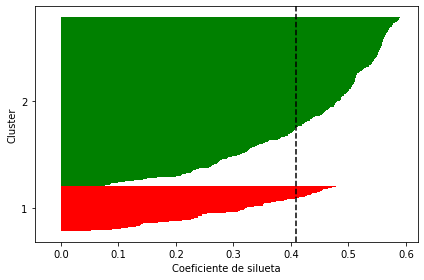

In [44]:
k=2
kmeans = KMeans(n_clusters=k, random_state=0, n_init=10)
kmeans.fit(dataStd)
y_clusters = kmeans.labels_
cluster_labels = np.unique(y_clusters)

silueta_puntos= silhouette_samples(dataStd, y_clusters, metric='euclidean')

y_ax_lower, y_ax_upper = 0, 0
yticks = []
colores = ['r', 'g', 'b', 'y', 'o']
for i, c in enumerate(cluster_labels):
    silueta_puntos_c = silueta_puntos[y_clusters == c]
    silueta_puntos_c.sort()
    y_ax_upper += len(silueta_puntos_c)
    color = colores[i]
    plt.barh(range(y_ax_lower, y_ax_upper), silueta_puntos_c, height=1.0, 
             edgecolor='none', color=color)

    yticks.append((y_ax_lower + y_ax_upper) / 2.)
    y_ax_lower += len(silueta_puntos_c)
    
silueta_promedio = np.mean(silueta_puntos)
plt.axvline(silueta_promedio, color="black", linestyle="--") 

plt.yticks(yticks, cluster_labels + 1)
plt.ylabel('Cluster')
plt.xlabel('Coeficiente de silueta')

plt.tight_layout()
# plt.savefig('./figures/silhouette.png', dpi=300)
plt.show()

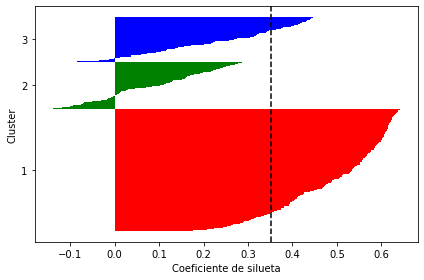

In [45]:
k=3
kmeans = KMeans(n_clusters=k, random_state=0, n_init=10)
kmeans.fit(dataStd)
y_clusters = kmeans.labels_
cluster_labels = np.unique(y_clusters)

silueta_puntos= silhouette_samples(dataStd, y_clusters, metric='euclidean')

y_ax_lower, y_ax_upper = 0, 0
yticks = []
colores = ['r', 'g', 'b', 'y', 'o']
for i, c in enumerate(cluster_labels):
    silueta_puntos_c = silueta_puntos[y_clusters == c]
    silueta_puntos_c.sort()
    y_ax_upper += len(silueta_puntos_c)
    color = colores[i]
    plt.barh(range(y_ax_lower, y_ax_upper), silueta_puntos_c, height=1.0, 
             edgecolor='none', color=color)

    yticks.append((y_ax_lower + y_ax_upper) / 2.)
    y_ax_lower += len(silueta_puntos_c)
    
silueta_promedio = np.mean(silueta_puntos)
plt.axvline(silueta_promedio, color="black", linestyle="--") 

plt.yticks(yticks, cluster_labels + 1)
plt.ylabel('Cluster')
plt.xlabel('Coeficiente de silueta')

plt.tight_layout()
# plt.savefig('./figures/silhouette.png', dpi=300)
plt.show()

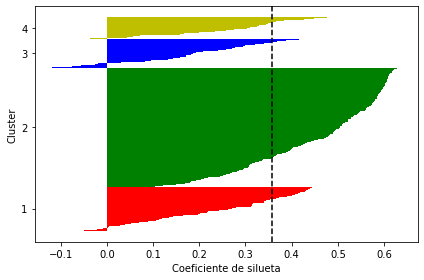

In [46]:
k=4
kmeans = KMeans(n_clusters=k, random_state=0, n_init=10)
kmeans.fit(dataStd)
y_clusters = kmeans.labels_
cluster_labels = np.unique(y_clusters)

silueta_puntos= silhouette_samples(dataStd, y_clusters, metric='euclidean')

y_ax_lower, y_ax_upper = 0, 0
yticks = []
colores = ['r', 'g', 'b', 'y', 'o']
for i, c in enumerate(cluster_labels):
    silueta_puntos_c = silueta_puntos[y_clusters == c]
    silueta_puntos_c.sort()
    y_ax_upper += len(silueta_puntos_c)
    color = colores[i]
    plt.barh(range(y_ax_lower, y_ax_upper), silueta_puntos_c, height=1.0, 
             edgecolor='none', color=color)

    yticks.append((y_ax_lower + y_ax_upper) / 2.)
    y_ax_lower += len(silueta_puntos_c)
    
silueta_promedio = np.mean(silueta_puntos)
plt.axvline(silueta_promedio, color="black", linestyle="--") 

plt.yticks(yticks, cluster_labels + 1)
plt.ylabel('Cluster')
plt.xlabel('Coeficiente de silueta')

plt.tight_layout()
# plt.savefig('./figures/silhouette.png', dpi=300)
plt.show()

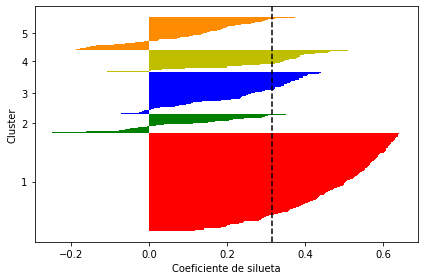

In [47]:
k=5
kmeans = KMeans(n_clusters=k, random_state=0, n_init=10)
kmeans.fit(dataStd)
y_clusters = kmeans.labels_
cluster_labels = np.unique(y_clusters)

silueta_puntos= silhouette_samples(dataStd, y_clusters, metric='euclidean')

y_ax_lower, y_ax_upper = 0, 0
yticks = []
colores = ['red', 'g', 'b', 'y', 'darkorange']
for i, c in enumerate(cluster_labels):
    silueta_puntos_c = silueta_puntos[y_clusters == c]
    silueta_puntos_c.sort()
    y_ax_upper += len(silueta_puntos_c)
    color = colores[i]
    plt.barh(range(y_ax_lower, y_ax_upper), silueta_puntos_c, height=1.0, 
             edgecolor='none', color=color)

    yticks.append((y_ax_lower + y_ax_upper) / 2.)
    y_ax_lower += len(silueta_puntos_c)
    
silueta_promedio = np.mean(silueta_puntos)
plt.axvline(silueta_promedio, color="black", linestyle="--") 

plt.yticks(yticks, cluster_labels + 1)
plt.ylabel('Cluster')
plt.xlabel('Coeficiente de silueta')

plt.tight_layout()
# plt.savefig('./figures/silhouette.png', dpi=300)
plt.show()

Con el método de silueta lo más indicado podría ser solo considerar dos clusters.

## Calinski-Harabaz

Intentemos ahora con la métrica de Calinski-Harabasz

In [48]:
CHs = []
for i in range(2,15) :
    km = KMeans(n_clusters=i, random_state=0)
    km.fit(dataStd)
    CH = calinski_harabaz_score(dataStd, km.labels_) 
    CHs.append(CH)
CHs

[209.86897766482454,
 194.00579183240123,
 167.73906664721594,
 157.41517713853025,
 154.69669764005556,
 145.96890836620057,
 138.39611914110506,
 132.7539850664708,
 124.75142151478825,
 120.48063172271965,
 117.2149671681171,
 113.81035830790195,
 109.12005232140574]

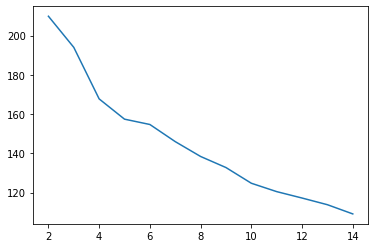

In [49]:
plt.plot(range(2, 15), CHs)

Para este criterio, el mayor score está en K=2, al igual que con el método de silueta. Pero como ya dijimos, no nos convendría mucho un clustering con solo dos segmentos para este caso de aplicación.
Encontramos que entre mas pequeño el K mejor, pero vemos que después de K=6 encontramos una gran desmejoría.